In [25]:
import numpy as np
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt

In [115]:
train = "/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/drowsiness-dataset/train"

In [116]:
labels = os.listdir(train)

In [56]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

# Visualize random

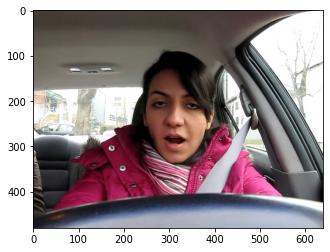

In [80]:
plt.imshow(plt.imread(f"{train}/yawn/10.jpg"))

In [81]:
a = plt.imread(f"{train}/yawn/10.jpg")
a.shape

(480, 640, 3)

In [124]:
li = os.listdir("/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_frontalface_default.xml")
li

NotADirectoryError: [Errno 20] Not a directory: '/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_frontalface_default.xml'

In [125]:
def face_for_yawn(direc=train, face_cas_path='/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_frontalface_default.xml'):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


In [126]:
yawn_no_yawn = face_for_yawn()

0
1


In [127]:
def get_data(dir_path=train, face_cas="/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_frontalface_default.xml", eye_cas='/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/assets/haarcascade_eye.xml'):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [128]:
data_train = get_data()

2
3


In [129]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [130]:
new_data = append_data()

0
1
2
3


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [131]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [132]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [138]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [139]:
y = np.array(y)

## train test split

In [140]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [175]:
X_train.shape, X_test.shape

((1347, 145, 145, 3), (578, 145, 145, 3))

In [149]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras

## Data Augmentation

In [150]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Model

In [151]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [152]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 279s 6s/step - loss: 1.2320 - accuracy: 0.4150 - val_loss: 0.9379 - val_accuracy: 0.6471
Epoch 2/50
43/43 [==============================] - 274s 6s/step - loss: 0.5772 - accuracy: 0.7543 - val_loss: 0.4064 - val_accuracy: 0.8304
Epoch 3/50
43/43 [==============================] - 273s 6s/step - loss: 0.4207 - accuracy: 0.8300 - val_loss: 0.3584 - val_accuracy: 0.8426
Epoch 4/50
43/43 [==============================] - 271s 6s/step - loss: 0.3578 - accuracy: 0.8575 - val_loss: 0.2623 - val_accuracy: 0.9031
Epoch 5/50
43/43 [==============================] - 270s 6s/step - loss: 0.3106 - accuracy: 0.8738 - val_loss: 0.2758 - val_accuracy: 0.8841
Epoch 6/50
43/43 [==============================] - 270s 6s/step - loss: 0.2693 - accuracy: 0.8968 - val_loss: 0.2151 - val_accuracy: 0.9066
Epoch 7/50
43/43 [==============================] - 272s 6s/step - loss: 0.2516 - accuracy: 0.8894 - val_loss: 0.2151 - val_accuracy: 0.9135
Epoch 8/50
43

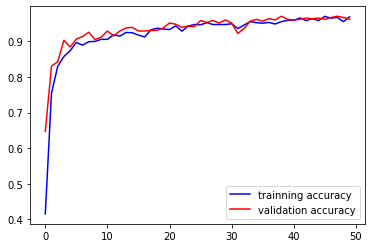

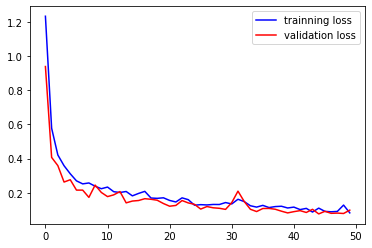

In [153]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## 2°

In [1]:
import glob

In [4]:
for e in glob.glob("/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/drowsiness-dataset/*/*/*"):
    parts = e.split("/")
    print(parts)
    break
    

['', 'mnt', 'd', 'Bootcamp Python', 'FINAL PROJECT', 'Final-Project-BDML', 'Data', 'drowsiness-dataset', 'train', 'bored', '0001.jpg']


In [8]:
def standarize(e):
    try: 
        parts = e.split("/")
        img = cv2.imread(e)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        obj = {
            "label":parts[3],
            "file":e,
            "img":img
        }
        return obj
    except Exception as err:
        print(f"Can not load image {e}")
        return None

In [13]:
x = [standarize(e) for e in glob.glob("/mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/drowsiness-dataset/")]

Can not load image /mnt/d/Bootcamp Python/FINAL PROJECT/Final-Project-BDML/Data/drowsiness-dataset/


In [7]:
len(x)

0